To install helix, run `pip install -e /path/to/helix/repo` 

In [7]:
import numpy as np
import strax as sx
import numba
import pandas as pd
import scipy as sp
import sys
import os
import helix as hx
import shutil
from glob import glob
from matplotlib import pyplot as plt


## Generate toy data

In [8]:
run_id = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel
# remove helix data corresponding to this run_id, if it exists
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
hx.generate_toy_data(run_id, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)

100%|█████████████████████████████████████████████| 1/1 [00:43<00:00, 43.85s/it]


In [9]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']
fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type


Loading events: |                     | 0.00 % [00:17<?], #2 (9.12 s). 64.6 MB/s

Source finished!


Loading events: |                     | 0.00 % [00:17<?], #2 (9.12 s). 64.6 MB/s
Loading fit_results: |                 | 0.00 % [00:17<?], #6 (2.67 s). 7.2 kB/s


## Process toy data

In [3]:
# creating context, registering storage and plugins
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

context.set_config(config)

fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type

# fit_results is a structured numpy array of events containing fields described in the FitResults documentation
# one can work with it as a dictionary on numpy arrays, or as a numpy array of dictionaries. Works both ways. E.g.
# fit_results['sum_uv_amplitude'][:100]  # amplitudes of UV signals in the sum of all channels in the first 100 events
# fit_results[:100]['sum_uv_amplitude']  # same

Loading fit_results: |                                        | 0.00 % [00:00<?]

Source finished!


Loading fit_results: |                 | 0.00 % [00:33<?], #2 (9.09 s). 4.9 kB/s


Loading events: |                   | 0.00 % [00:00<?], #6 (0.10 s). 1973.8 MB/s


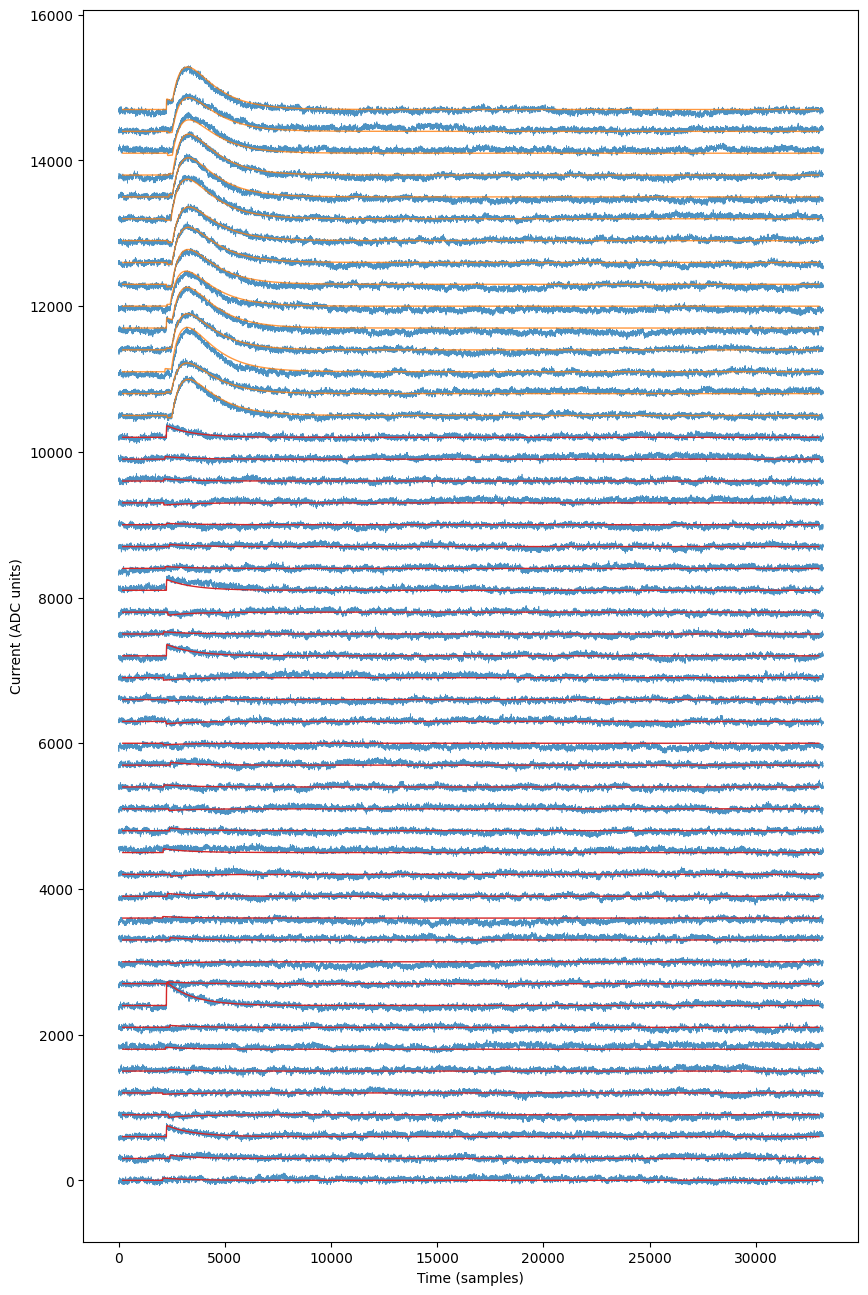

In [6]:
# Building the channel map and loading the templates
events = context.get_array(run_id, 'events')
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

template_path = './plugins/event_rqs/default_templates.npy'
templates = np.load(template_path, allow_pickle=True)
uv_template = templates[0]
qp_template = templates[1]
# change this to choose another event if the one below is a bad one by chance
i = 7

plt.figure(figsize=(10,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][i].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel

event = fit_results[i]

# plotting two-template fits in the vacuum channels
for i_vac, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.VACUUM)):
    # i_vac is the ordinal index of the vacuum channel
    # i_ch is the corrending ordinal index in the array of all channels
    fit = event['vacuum_channel_uv_amplitude'][i_vac] * np.roll(uv_template, event['vacuum_channel_uv_offset'][i_vac]) + \
          event['vacuum_channel_qp_amplitude'][i_vac] * np.roll(qp_template, event['vacuum_channel_qp_offset'][i_vac])
    x = np.arange(len(uv_template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]  # currently, the FitResults plugin does not fit the entire event. It skips -hx.DEFAULT_ALLOWED_FIT_SHIFTS[0] samples.
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, alpha=0.8, color='C1')

# plotting one-template fits in the submerged channels
for i_sub, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.SUBMERGED)):
    fit = event['submerged_channel_uv_amplitude'][i_sub] * np.roll(uv_template, event['submerged_channel_uv_offset'][i_sub])
    x = np.arange(len(uv_template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, color='C3')


plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.show()

In [2]:
from helix import units
import numpy as np
import helix as hx
def make_default_templates():
    uv_template = hx.get_analytical_template(length=hx.DEFAULT_OF_LENGTH, sampling_dt=hx.DEFAULT_SAMPLING_DT)
    qp_template = hx.get_analytical_template(2 * units.ms, length=hx.DEFAULT_OF_LENGTH,
                                             sampling_dt=hx.DEFAULT_SAMPLING_DT)
    templates = np.array([uv_template, qp_template])

    np.save('plugins/event_rqs/default_templates.npy', templates)
make_default_templates()